# Exploratory data analysis of ECMWF ERA5 dataset on climate variables

## Imports

In [308]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import datetime
import os
import warnings

## Loading and preparing data

In [309]:
path_to_data = '/home/philemonthalmann/Documents/AgERA5-PASTIS'

data = {}

for filename in os.listdir(path_to_data):
    if filename.endswith('.csv'):
        with open(os.path.join(path_to_data, filename)) as f:
            data[filename.split('.csv')[0]] = pd.read_csv(f, index_col=0)

def rename_columns(df):
    return df.rename(columns=lambda x: "Tile_1" if x.startswith('1')
                                    else "Tile_2" if x.startswith('2')
                                    else "Tile_3" if x.startswith('3')
                                    else "Tile_4" if x.startswith('4')
                                    else KeyError)

data_long = {}
for df_name, df in data.items():
    df_renamed = rename_columns(df)
    df_long = df_renamed.melt(var_name='Tile', value_name='Value')
    data_long[df_name] = df_long

## Correlation between (aggregated) variables 

<Figure size 3000x3000 with 0 Axes>

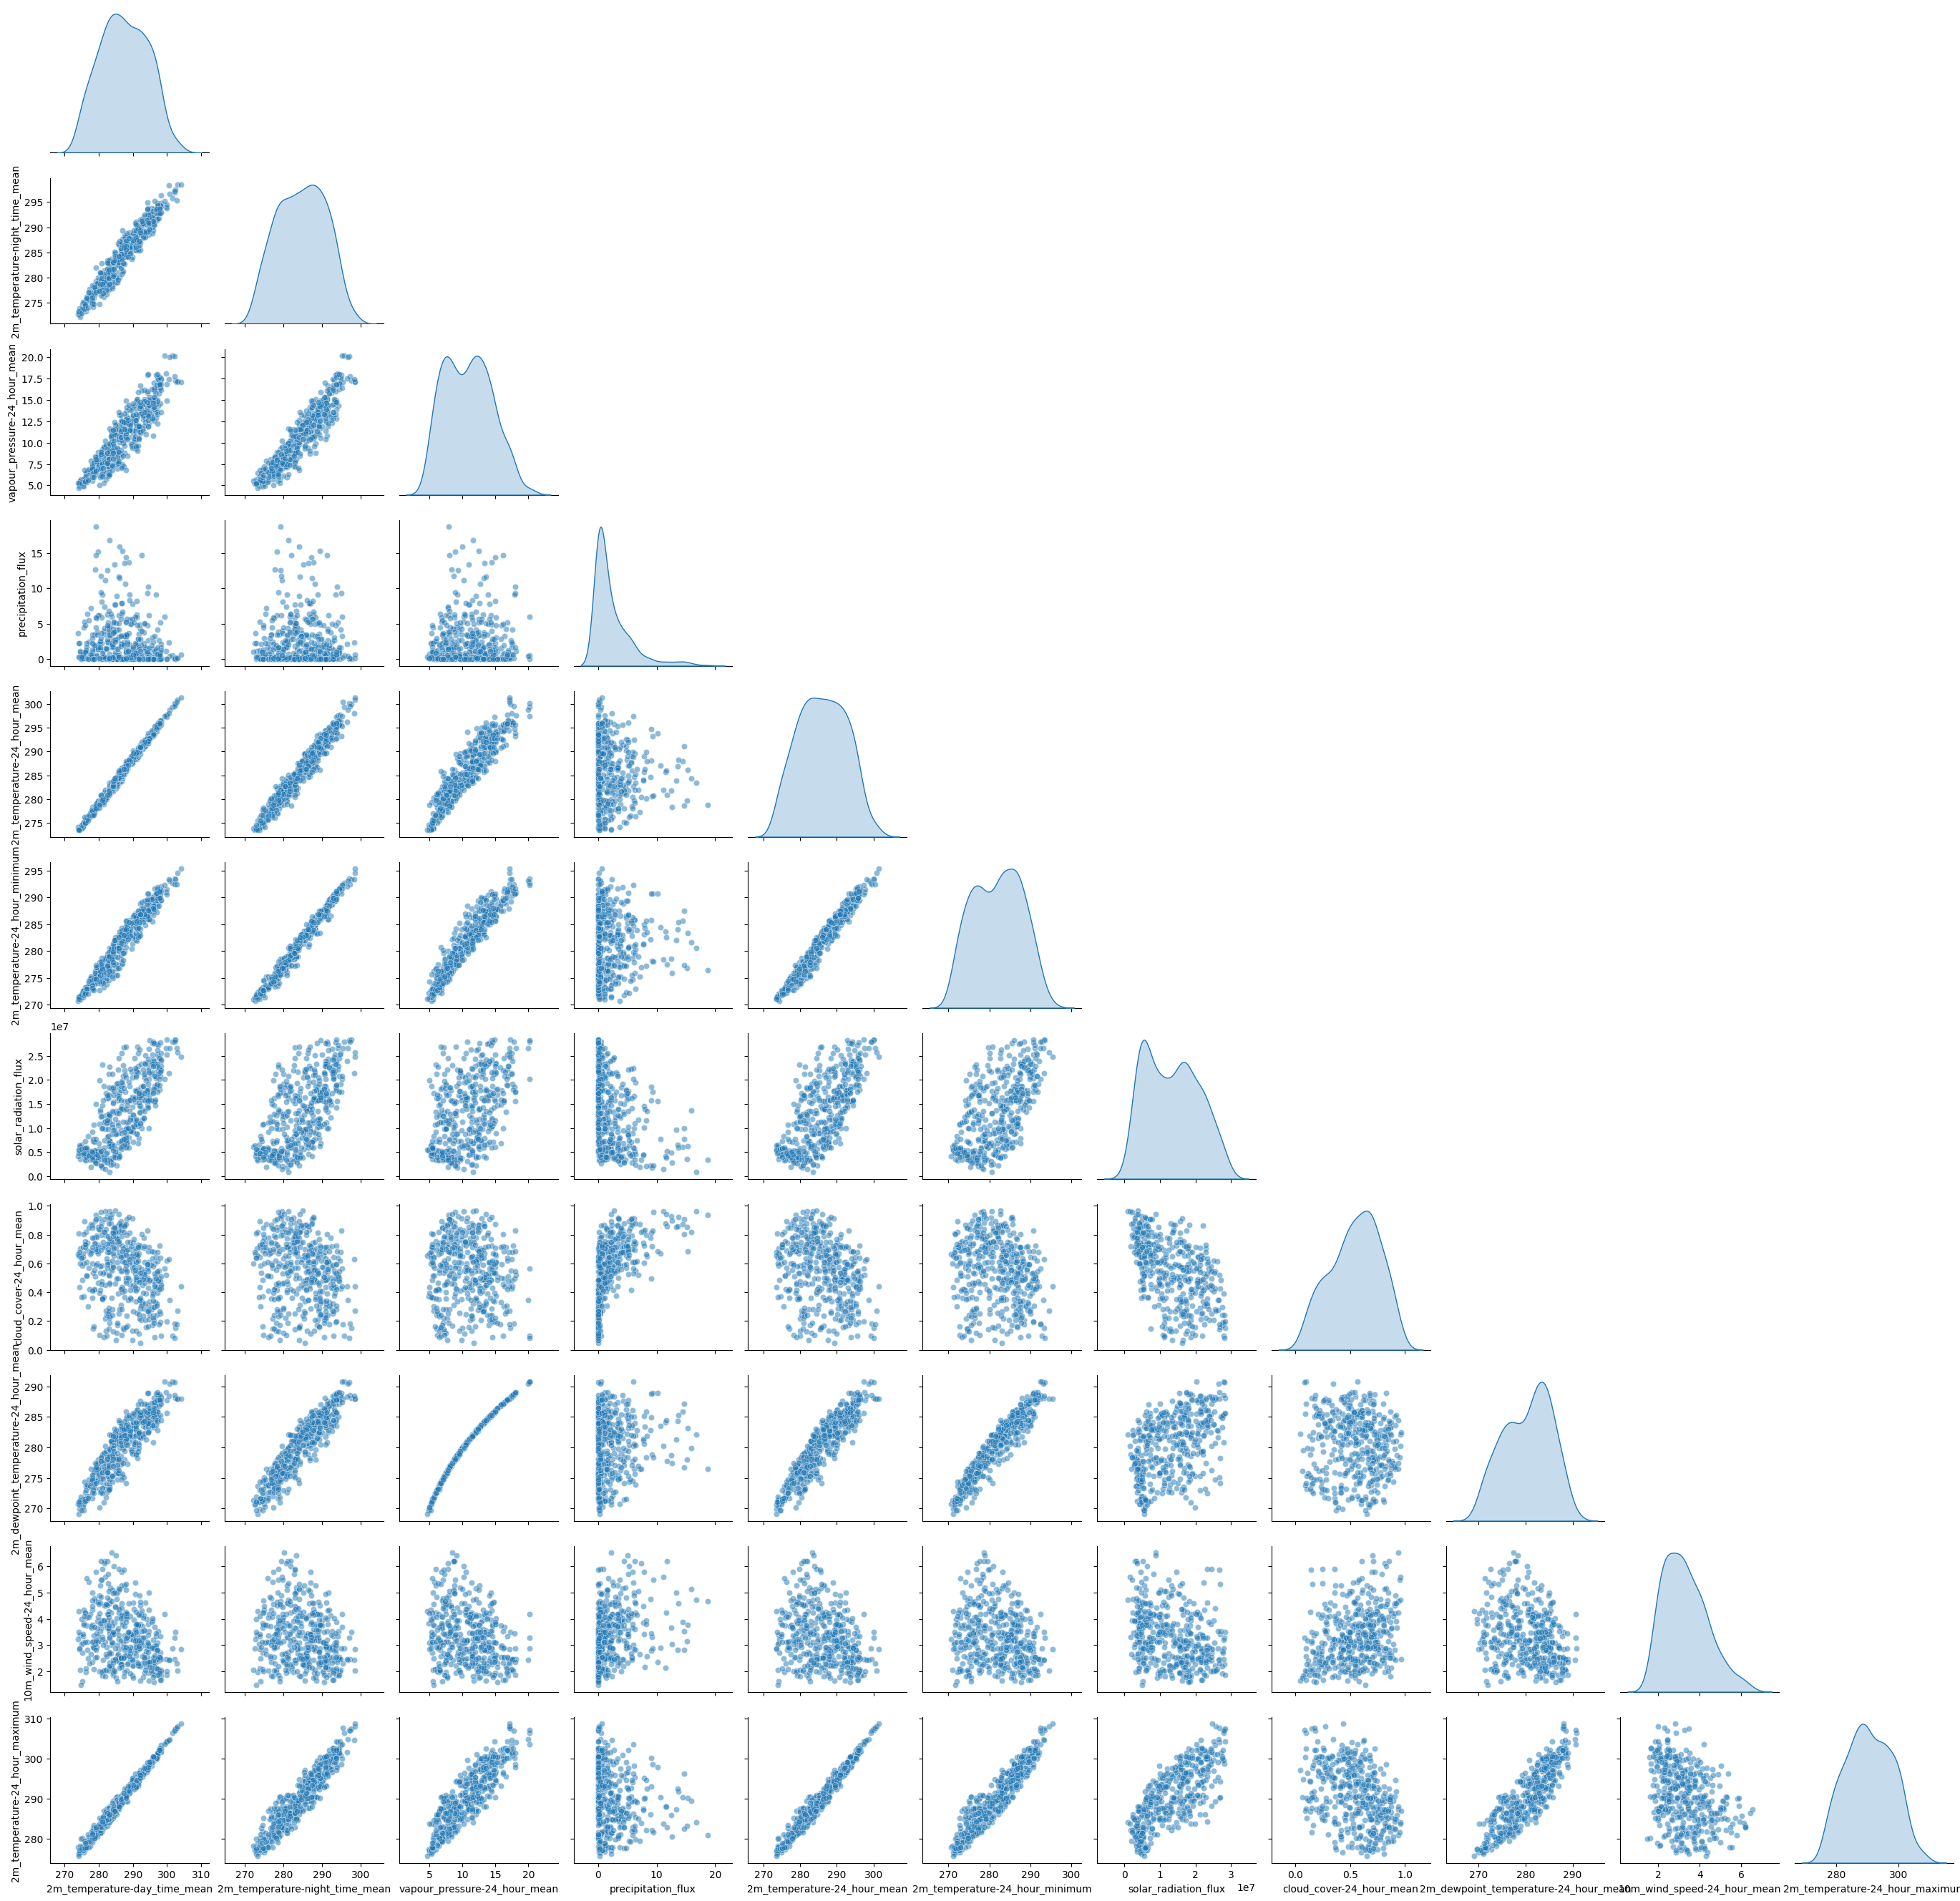

In [310]:
def pair_plot(data, variables, log_transform_percipitation=False):
    combined_df = pd.DataFrame()

    for var in variables:
        df2 = data[var].copy()
        df2.index = pd.to_datetime(df2.index, format='%Y%m%d')

        aggregated_data = df2.mean(axis=1)

        if var == 'precipitation_flux':
            if log_transform_percipitation:
                aggregated_data = np.log1p(aggregated_data) 

        combined_df[var] = aggregated_data


    combined_df.reset_index(inplace=True)
    combined_df.rename(columns={combined_df.columns[0]: 'Date'}, inplace=True)

    plt.figure(figsize=(30, 30))
    
    g = sns.pairplot(combined_df.drop(columns='Date'), diag_kind='kde', plot_kws={'alpha':0.5}, corner=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    plt.show()

variables = list(data.keys())
pair_plot(data, variables, log_transform_percipitation=False)

## Distribution and potential distribution shifts across tiles & patches

### KDE with integrated boxplot (violin plot)

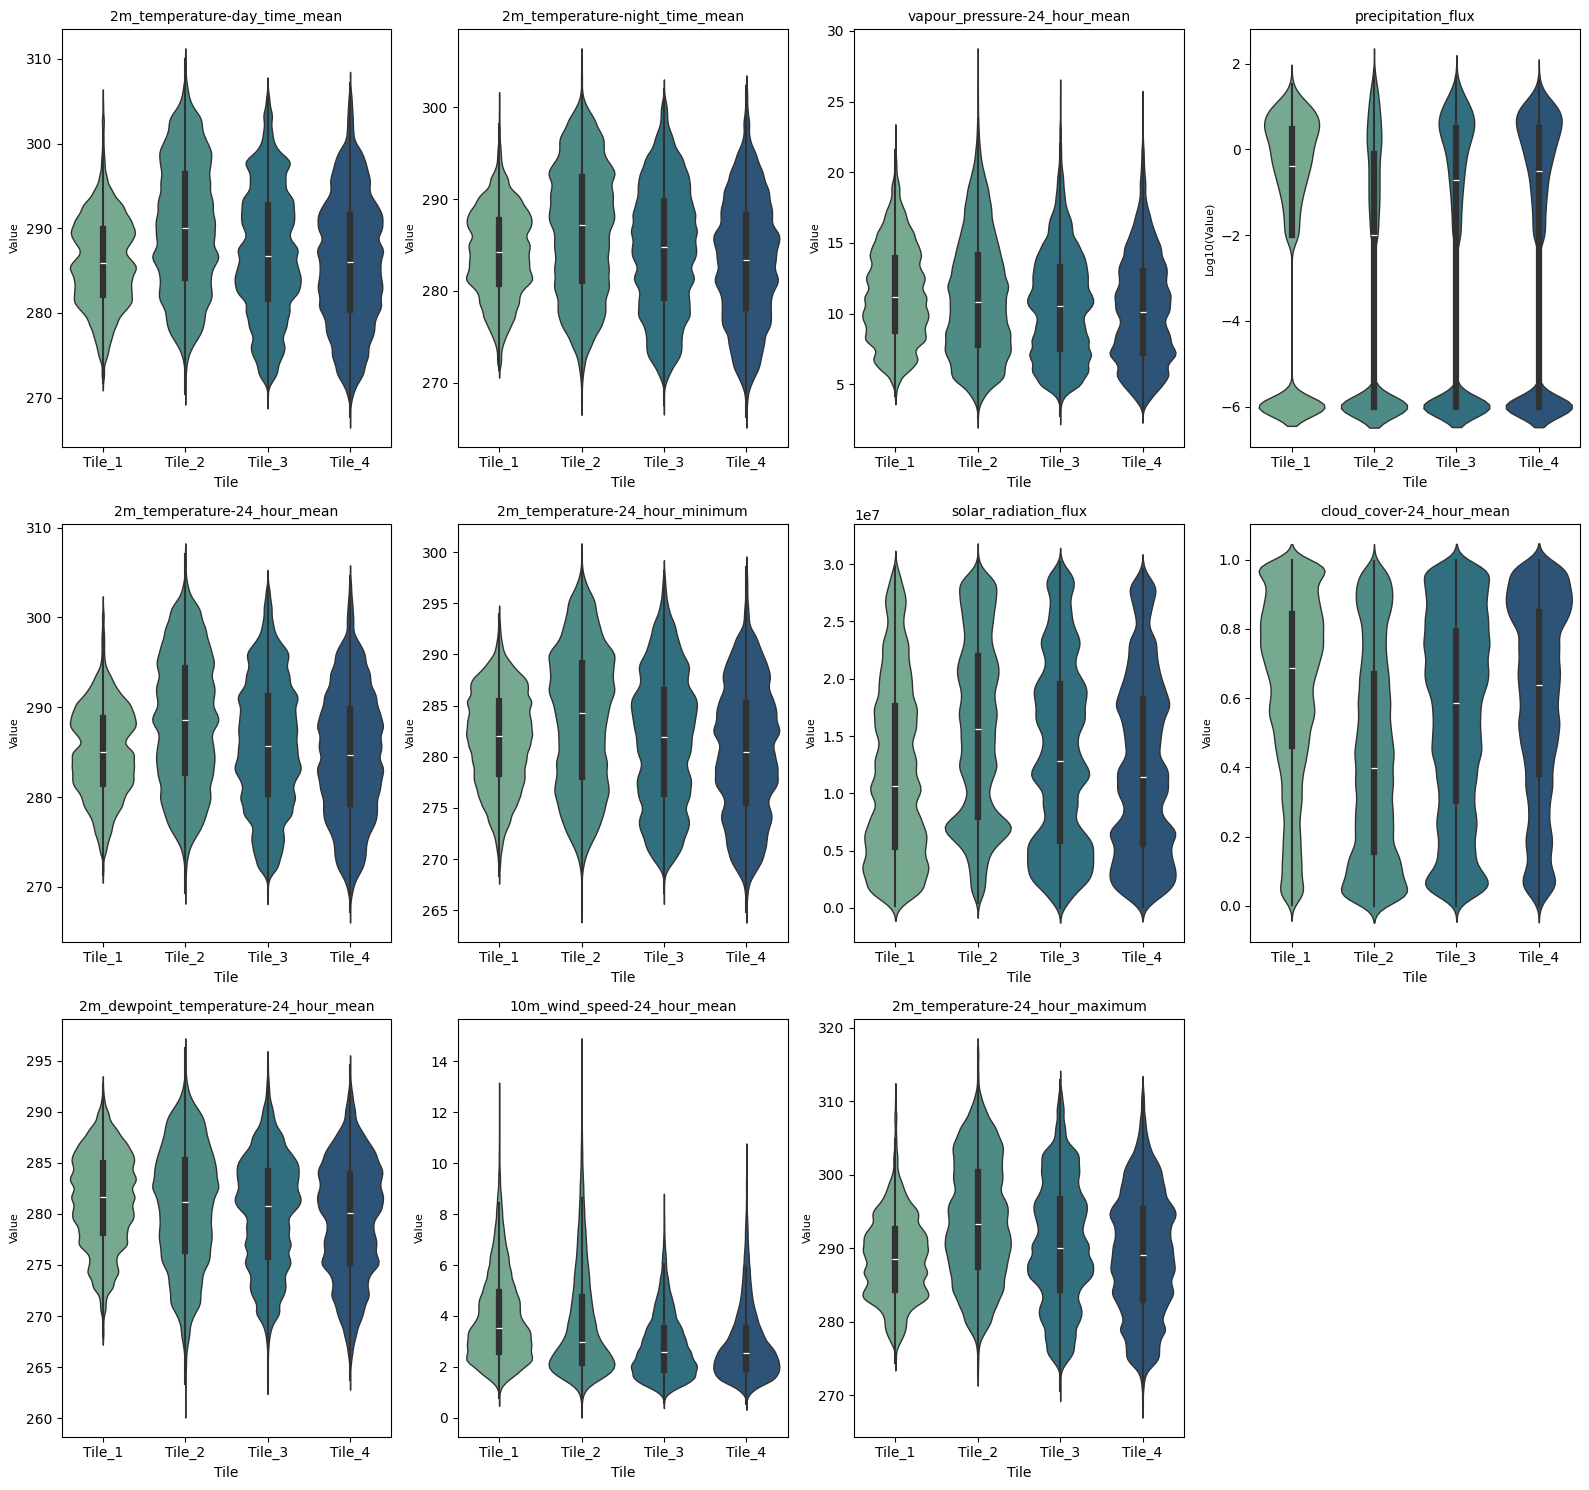

In [311]:
def plot_violin_grid(data_long, log_scale_vars=None, ncols=2):
    nrows = (len(data_long) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
    axes = axes.flatten()

    for i, (var_name, df_long) in enumerate(data_long.items()):
        if log_scale_vars and var_name in log_scale_vars:
            df_long["Value"] = np.log10(df_long["Value"] + 1e-6)
            y = "Value"
            y_label = "Log10(Value)"
        else:
            y = "Value"
            y_label = "Value"

        sns.violinplot(
            x='Tile', y=y, data=df_long, palette="crest", ax=axes[i],
            inner="box",  
            linewidth=1
        )
        axes[i].set_title(f'{var_name}', fontsize=10)
        axes[i].set_ylabel(y_label, fontsize=8)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

warnings.filterwarnings('ignore', category=FutureWarning)
plot_violin_grid(data_long, log_scale_vars=["precipitation_flux"], ncols=4)

### Time series heatmap across tiles

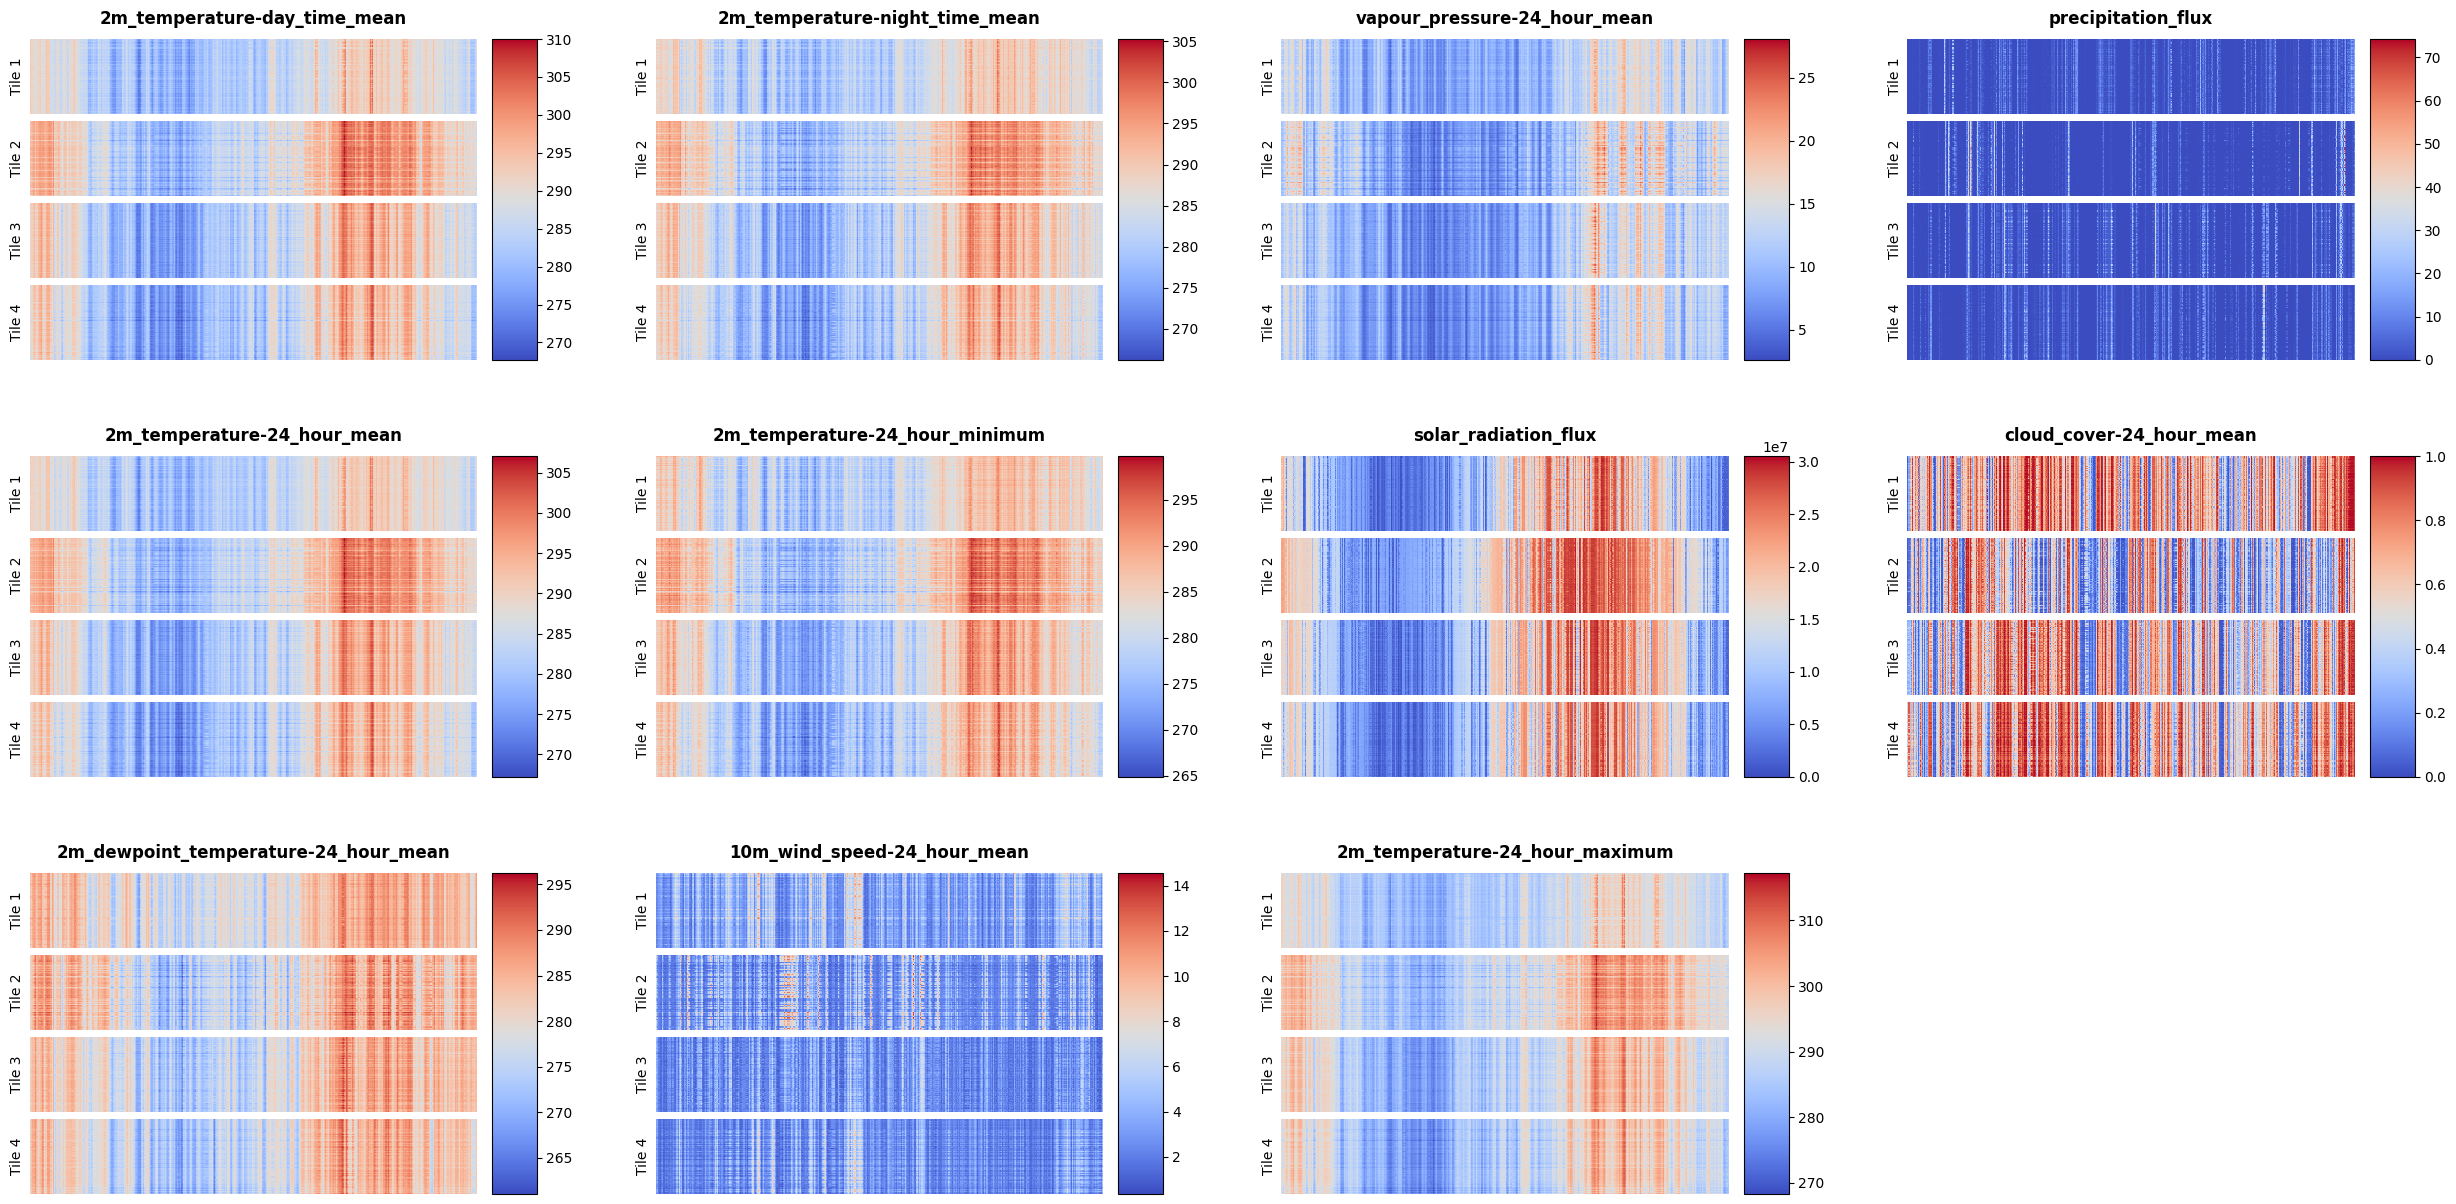

In [312]:
def plot_all_variables_heatmaps(data, variables, nrows=3, ncols=4, figsize=(20, 15)):
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.3, wspace=0.4)
       
    for idx, var in enumerate(variables):
        if idx >= nrows * ncols:
            break  

        df2 = data[var].copy()

        tiles = df2.columns.str[0].astype(int)
        df_transposed = df2.transpose()
        df_transposed.index = [f'Tile {x[0]}' for x in df_transposed.index]
        df_heatmap = df_transposed.reset_index()

        df_heatmap.columns = df_heatmap.columns.astype(str)
        date_columns = pd.to_datetime(df_heatmap.columns[1:], format='%Y%m%d')
        df_heatmap.columns = ['Tile'] + list(date_columns)
        df_heatmap = df_heatmap.set_index('Tile')

        global_min = df_heatmap.min().min()
        global_max = df_heatmap.max().max()

        ax = plt.Subplot(fig, gs[idx])

        inner_gs = gridspec.GridSpecFromSubplotSpec(nrows=4, ncols=1, subplot_spec=gs[idx], hspace=0.1)

        for i, tile in enumerate(df_heatmap.index.unique()):
            inner_ax = plt.Subplot(fig, inner_gs[i])
            sns.heatmap(df_heatmap.loc[tile], cmap='coolwarm', cbar=False,
                        vmin=global_min, vmax=global_max, ax=inner_ax)
            inner_ax.set_ylabel(tile)

            inner_ax.set_xticks([])
            inner_ax.set_xticklabels([])
            inner_ax.set_yticks([])
            inner_ax.set_yticklabels([])

            fig.add_subplot(inner_ax)

        cbar_ax = fig.add_axes([ax.get_position().x1 + 0.005, ax.get_position().y0, 0.015, ax.get_position().height])
        norm = mcolors.Normalize(vmin=global_min, vmax=global_max)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), cax=cbar_ax)

        title_y = ax.get_position().y1 + 0.01  
        fig.text(ax.get_position().x0 + ax.get_position().width/2, title_y, var, ha='center', fontsize=12, fontweight='bold')

        ax.axis('off')  

    plt.tight_layout()
    plt.show()

variables = list(data.keys())  
warnings.filterwarnings('ignore', category=UserWarning)
plot_all_variables_heatmaps(data, variables, nrows=3, ncols=4, figsize=(30, 15))


## Time Series Decomposition per variable (aggregated across tiles)

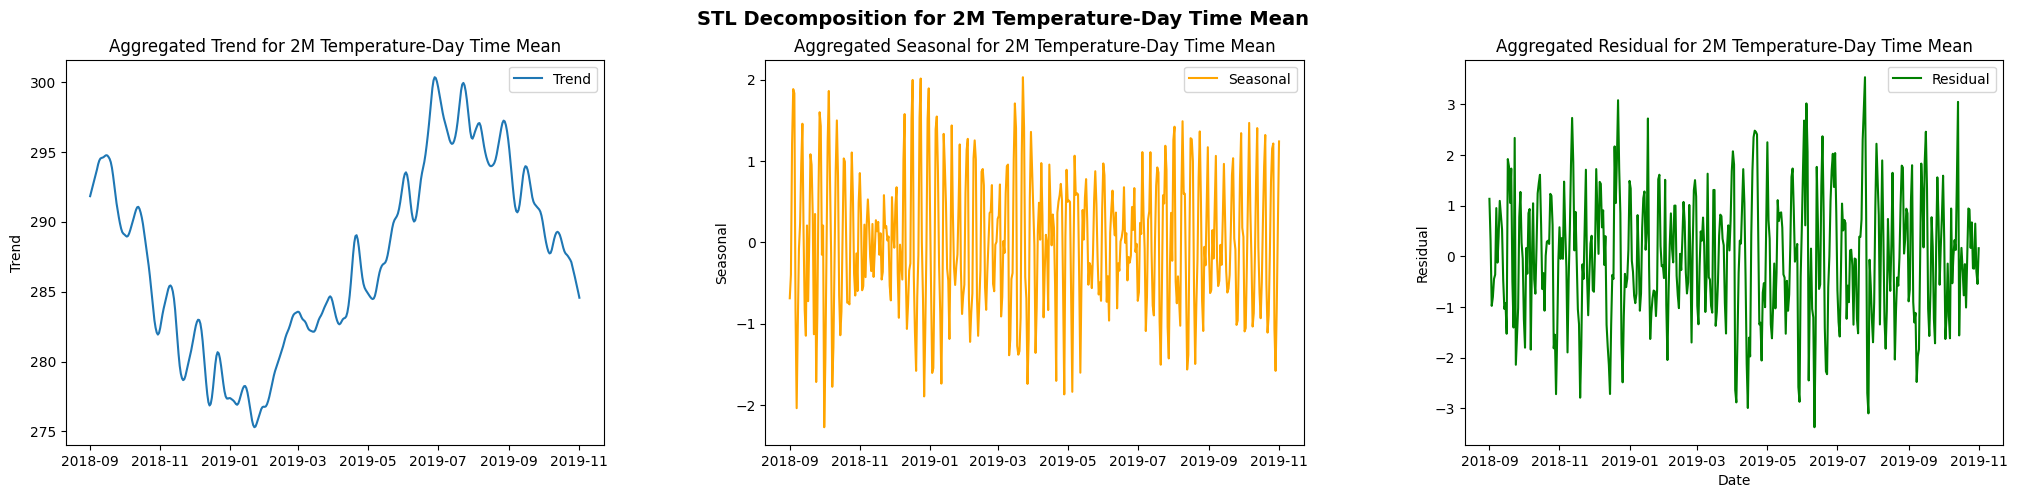

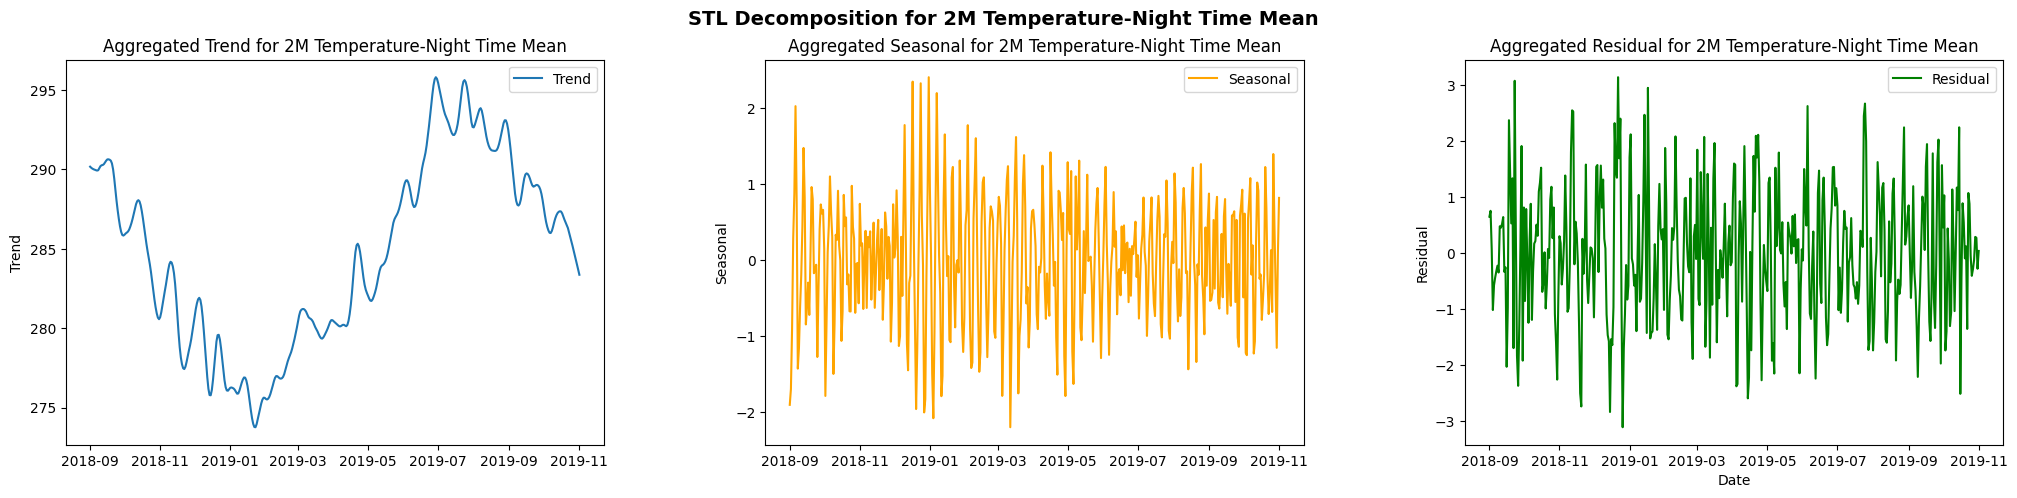

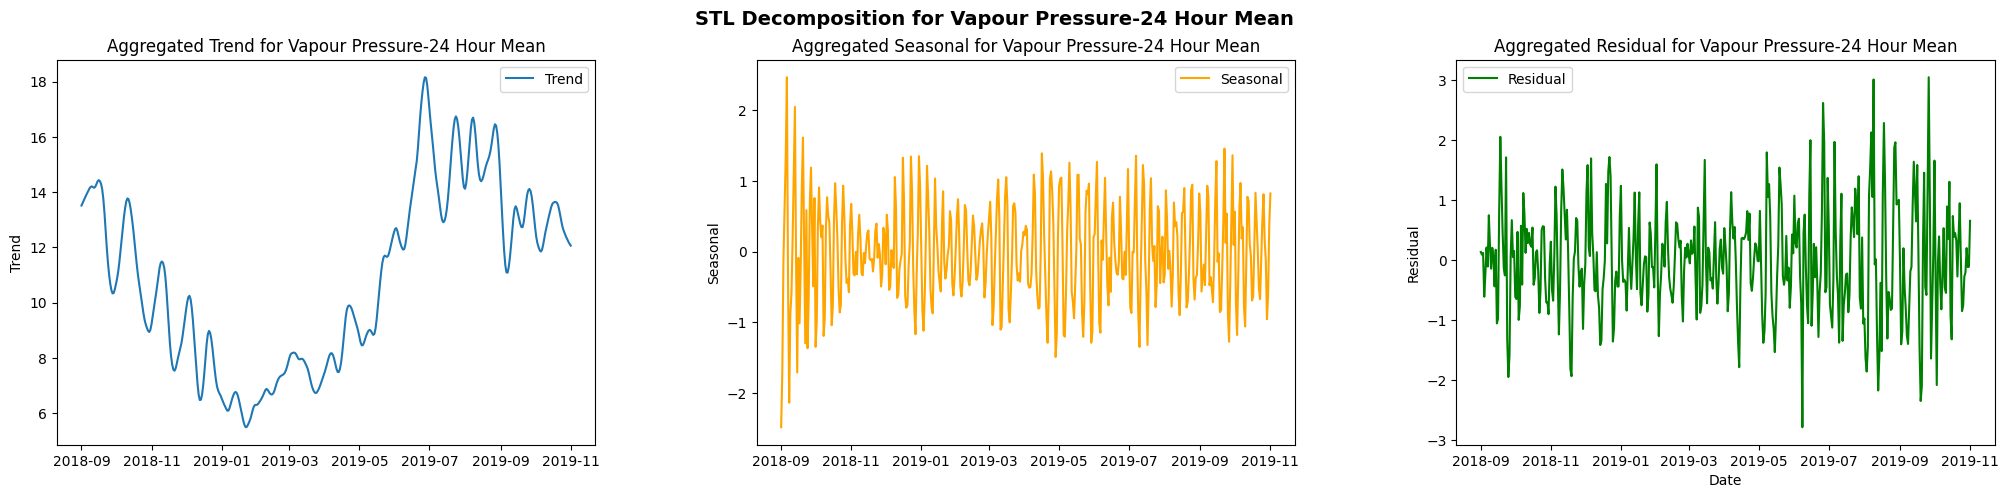

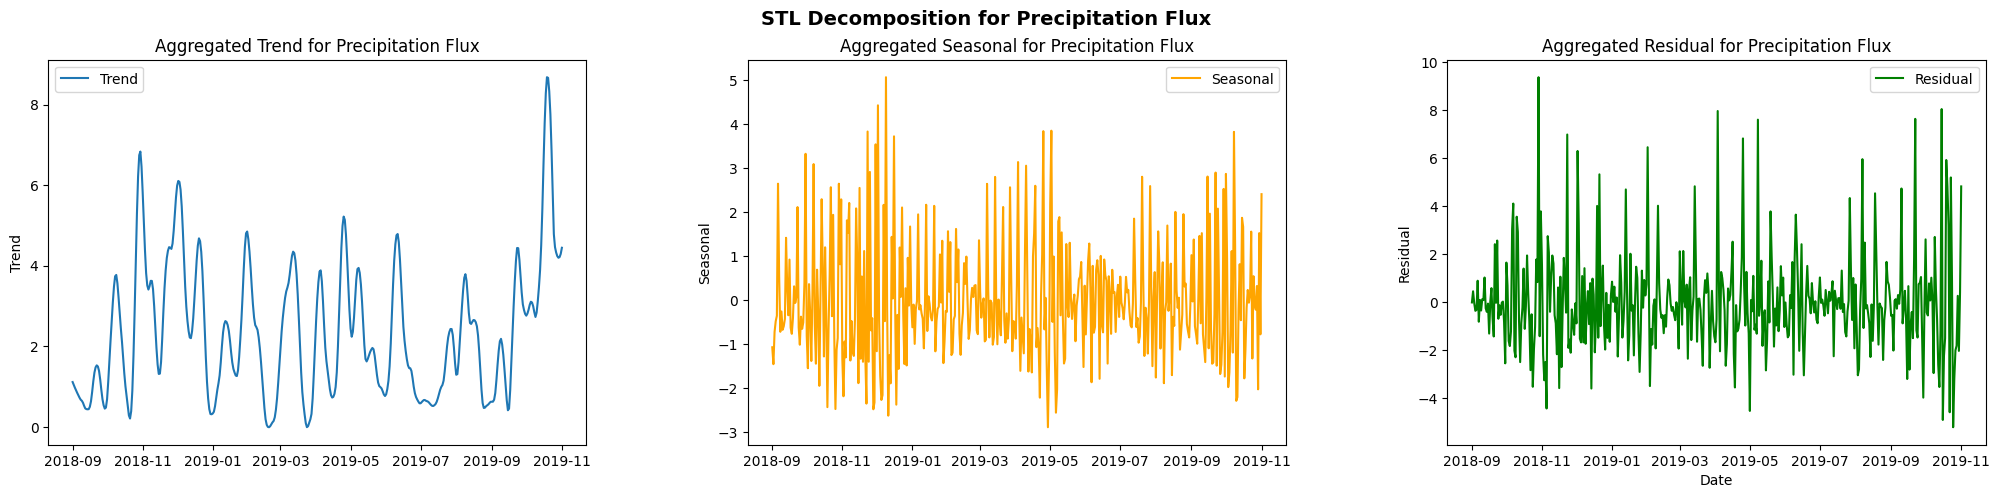

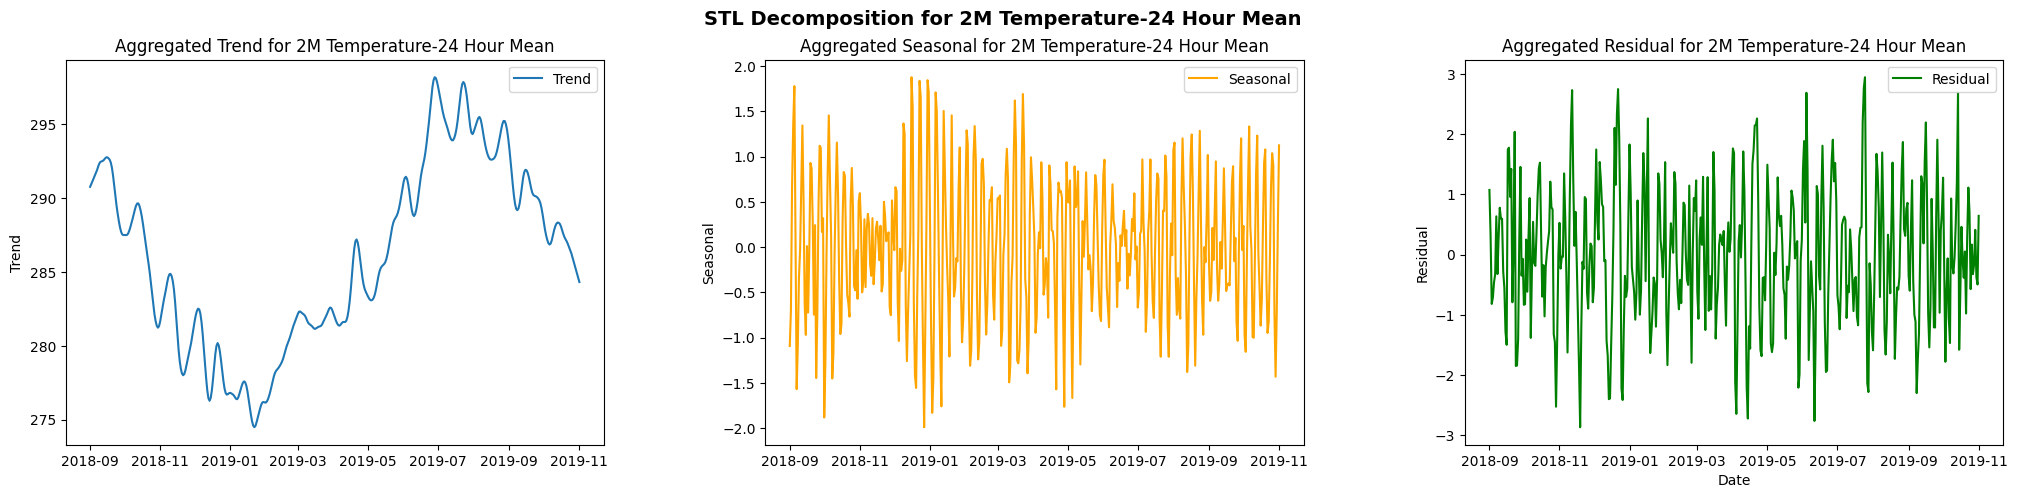

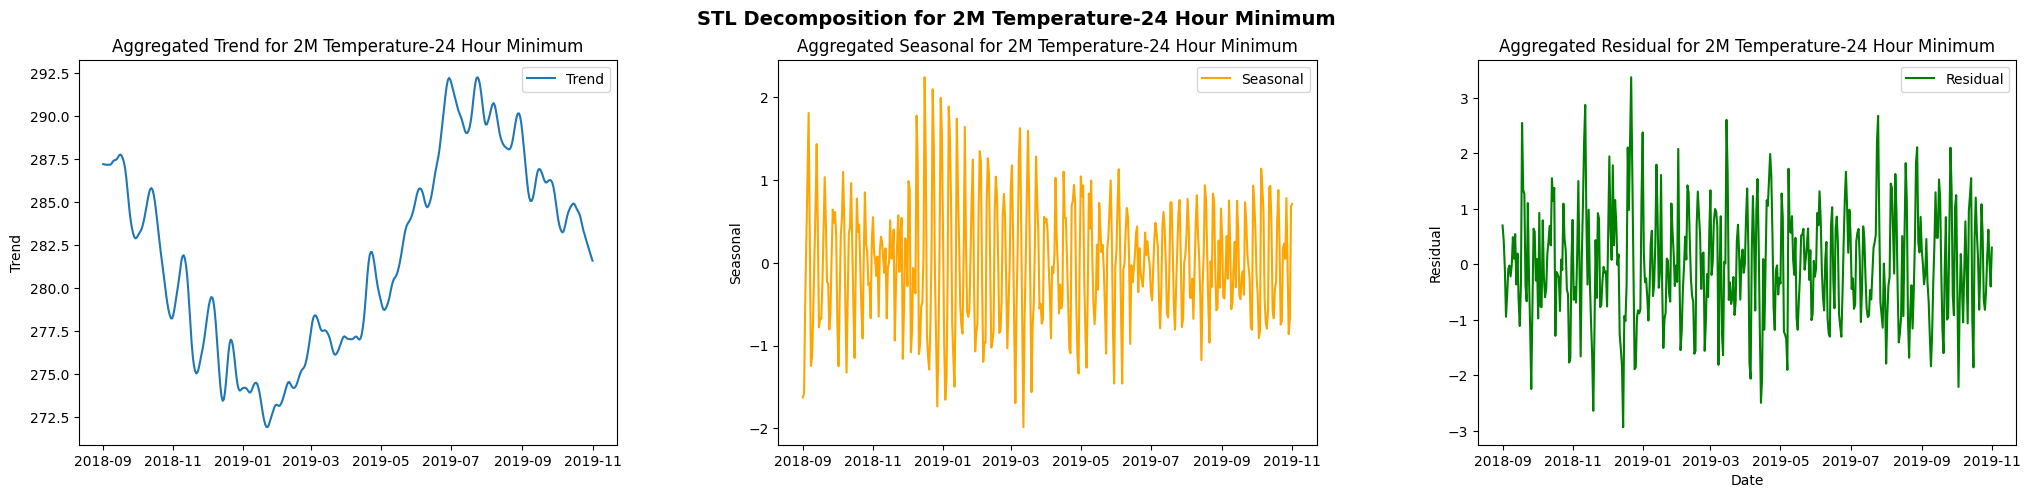

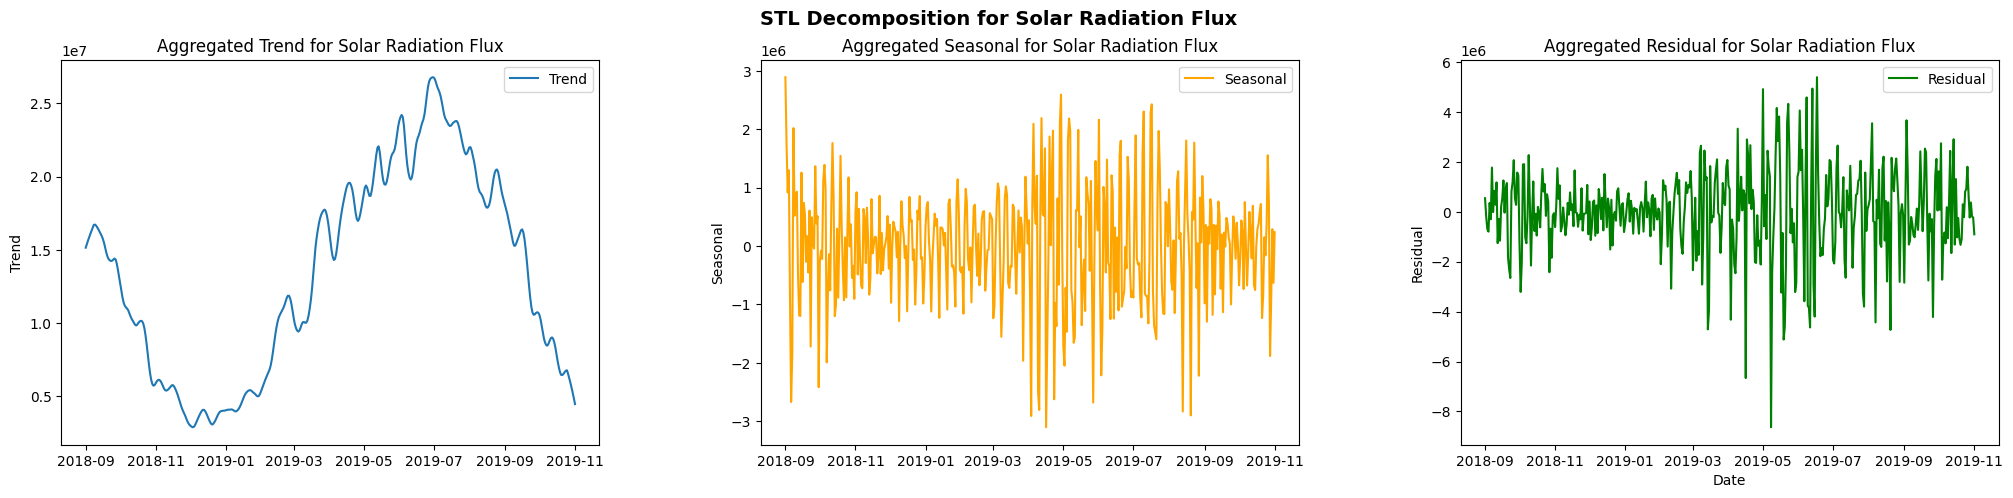

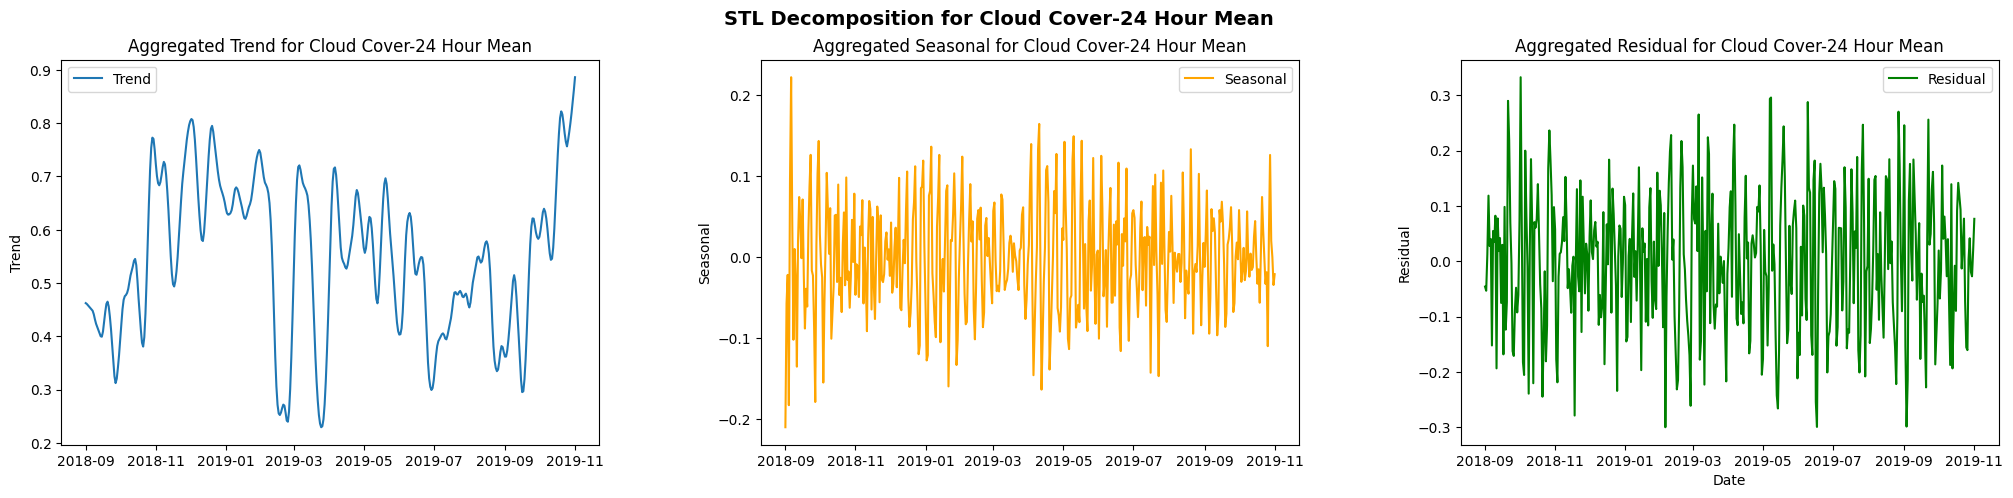

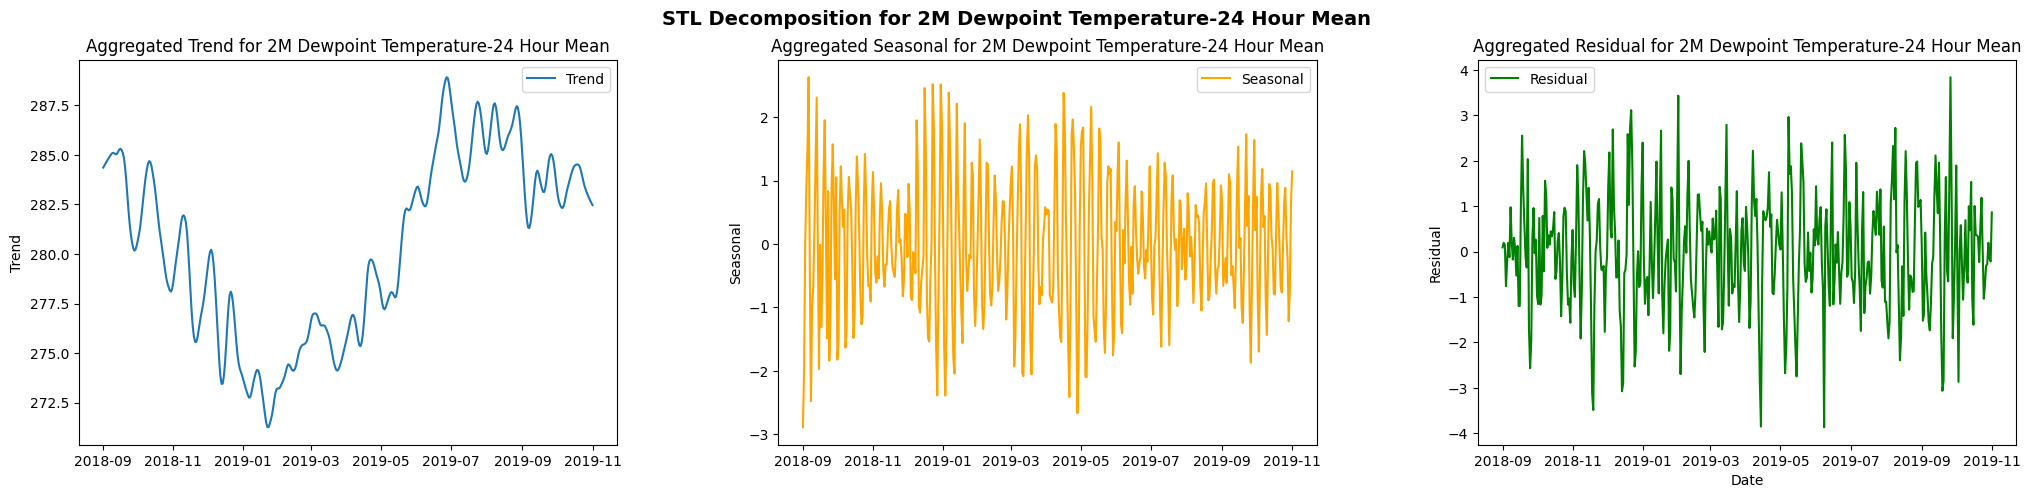

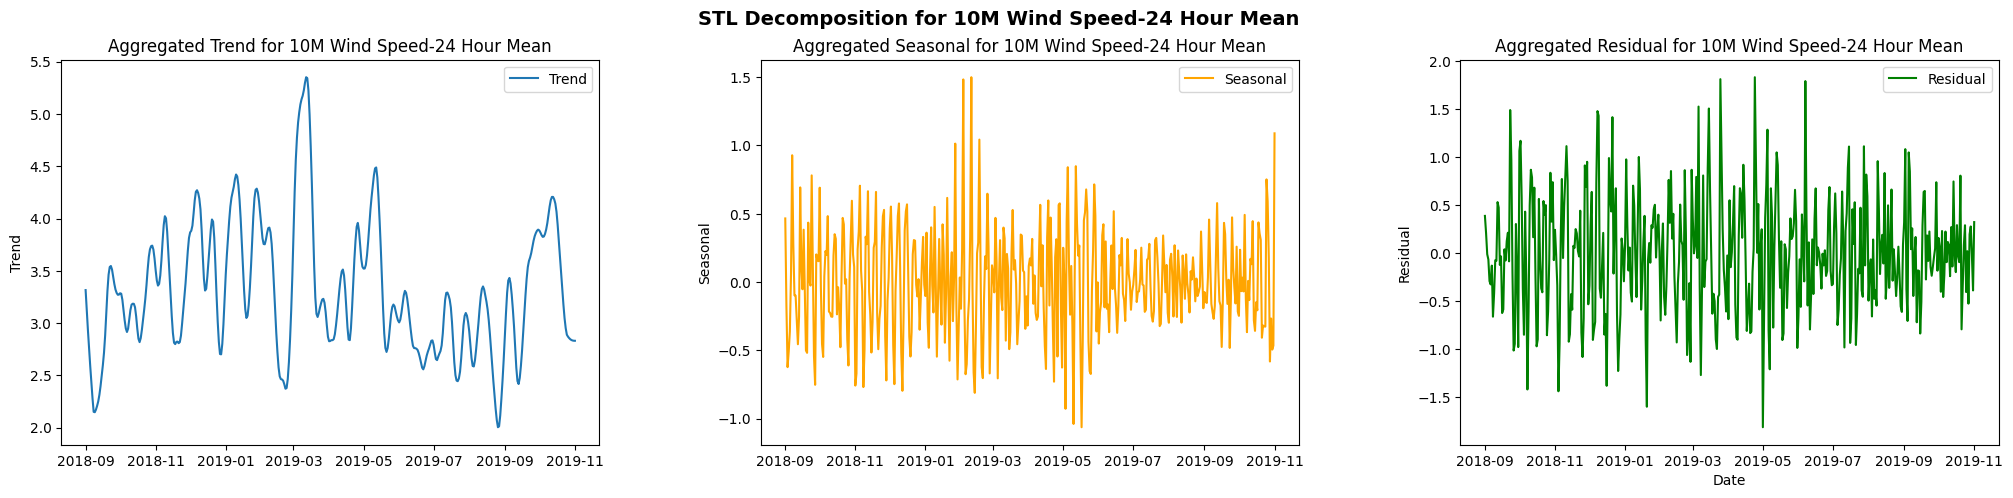

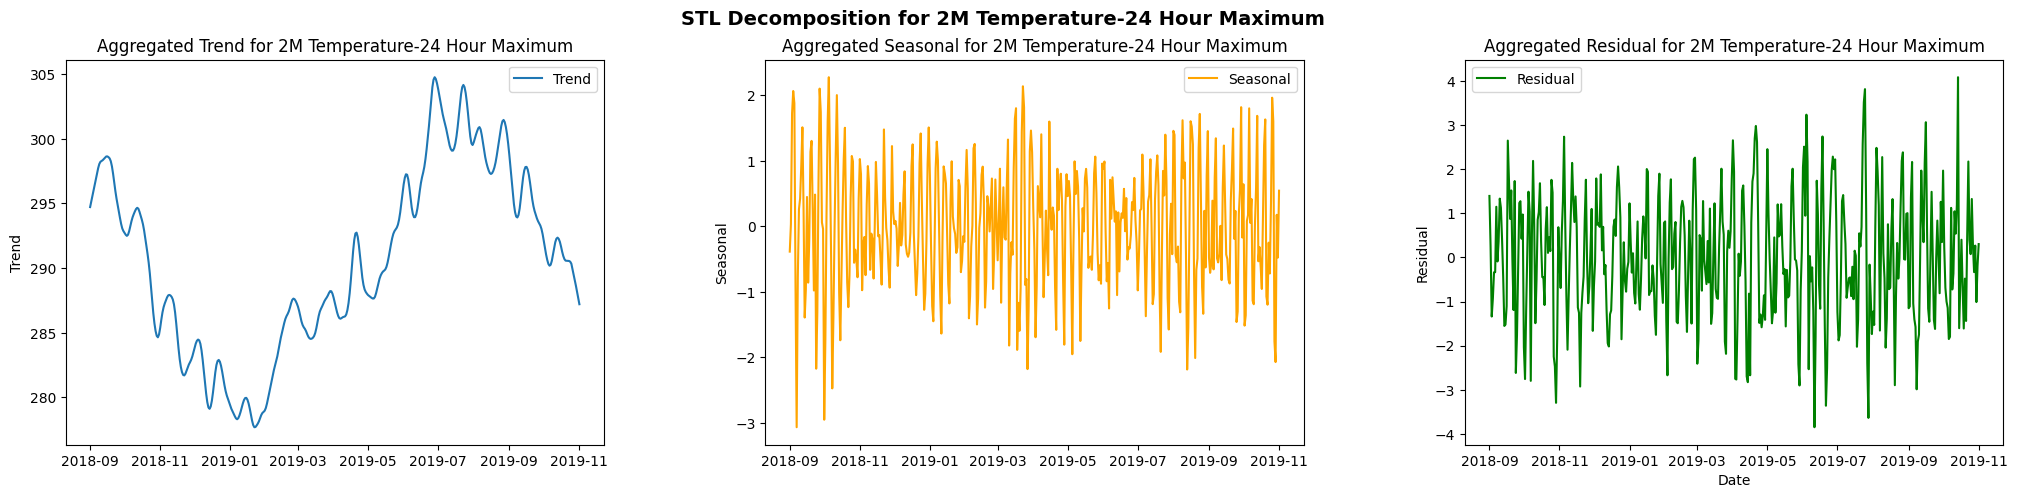

In [313]:
def decompose_and_plot_aggregated(data, variables, seasonal=7):
    for var in variables:
        df2 = data[var].copy()
        
        df2.index = pd.to_datetime(df2.index, format='%Y%m%d')  

        trend_aggregated = []
        seasonal_aggregated = []
        residual_aggregated = []
        
        tiles = sorted(set(col[0] for col in df2.columns))
        
        for tile in tiles:
            tile_columns = [col for col in df2.columns if col.startswith(str(tile))]
            tile_data = df2[tile_columns]

            for patch in tile_data.columns:
                series = tile_data[patch]
                stl = STL(series, seasonal=seasonal)
                result = stl.fit()
                
                trend_aggregated.append(result.trend)
                seasonal_aggregated.append(result.seasonal)
                residual_aggregated.append(result.resid)
        
        trend_df = pd.DataFrame(trend_aggregated).T
        seasonal_df = pd.DataFrame(seasonal_aggregated).T
        residual_df = pd.DataFrame(residual_aggregated).T
        
        trend_mean = trend_df.mean(axis=1)
        seasonal_mean = seasonal_df.mean(axis=1)
        residual_mean = residual_df.mean(axis=1)

        n_plots = 3 
        n_cols = 3
        n_rows = (n_plots + n_cols - 1) // n_cols  
        fig = plt.figure(figsize=(25, 5 * n_rows))
        gs = gridspec.GridSpec(nrows=n_rows, ncols=n_cols, hspace=0.4, wspace=0.3)
        
        ax1 = plt.subplot(gs[0])
        ax1.plot(df2.index, trend_mean, label='Trend')
        ax1.set_title(f'Aggregated Trend for {var.replace("_", " ").title()}')
        ax1.set_ylabel('Trend')
        ax1.legend()

        ax2 = plt.subplot(gs[1])
        ax2.plot(df2.index, seasonal_mean, label='Seasonal', color='orange')
        ax2.set_title(f'Aggregated Seasonal for {var.replace("_", " ").title()}')
        ax2.set_ylabel('Seasonal')
        ax2.legend()

        ax3 = plt.subplot(gs[2])
        ax3.plot(df2.index, residual_mean, label='Residual', color='green')
        ax3.set_title(f'Aggregated Residual for {var.replace("_", " ").title()}')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Residual')
        ax3.legend()

        plt.suptitle(f'STL Decomposition for {var.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.8])
        plt.show()

variables = list(data.keys())
warnings.filterwarnings('ignore', category=UserWarning)
decompose_and_plot_aggregated(data, variables, seasonal=7)